**Network generation and plotting in Python**

The following chunks of code generate several different types of networks of interest,
including B-A scale-free networks, W-S small world networks, E-R random
networks, and complete networks.

In [266]:
import numpy as np
import random

def BAgen(N,m):
    '''
    +++++++++++++++++++++++++++++++
    BAgen function: generates a B-A network
    +++++++++++++++++++++++++++++++
    N -- size of the final B-A network
    m -- no. of connections made with existing network per pass (suggested value of 1)
    '''

    if m > 5:
        print("ERROR: m must be less than 5!")
        return

    # initialize algorithm with seed
    seedNet = np.array([[0,1,0,0,1],[1,0,0,1,0],[0,0,0,1,0],[0,1,1,0,0],[1,0,0,0,0]])
    adjMat = seedNet

    numNodes = 5
    for i in range(N-5):
        # add edges until the desired no. of connections has been achieved
        cycleCounter = 0
        edgesAdded = 0
        # add new node to adjacency matrix
        adjMatOld = adjMat # store adjacency matrix prior to adjustments
        nodeVec = random.sample(range(adjMat.shape[0]),adjMat.shape[0])
        adjMat = np.vstack([adjMat, np.zeros(shape=(adjMat.shape[1],))])
        adjMat = np.hstack([adjMat, np.zeros(shape=(adjMat.shape[0],1))])
        while edgesAdded < m:
            newEdgeProb = sum(adjMatOld[nodeVec[cycleCounter],:])/sum(sum(adjMatOld))
            if (np.random.uniform() <= newEdgeProb) & (adjMat[numNodes,nodeVec[cycleCounter]] == 0):
                # add an edge
                adjMat[numNodes,nodeVec[cycleCounter]] = 1
                adjMat[nodeVec[cycleCounter],numNodes] = 1
                # update counters
                edgesAdded += 1
            cycleCounter += 1
            cycleCounter = cycleCounter % numNodes
            ## end of while loop
        # update no. of nodes in network
        numNodes += 1
        ## end of for loop


    return adjMat

The following chunks of code (i) generate a B-A graph using the above function and plot it using the `nx.draw_spring()`
function, and then (ii) ensure the network construction is accurate by plotting a histogram and a log-log plot
of the degree frequency vs. degree (the data should roughly fall on a straight line).

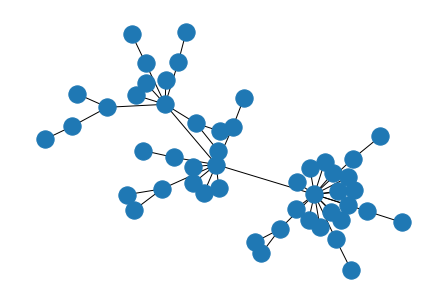

In [267]:
import networkx as nx

testMat = BAgen(50,1)
testMatGraph = nx.from_numpy_matrix(testMat)
nx.draw_spring(testMatGraph)

(200, 200)


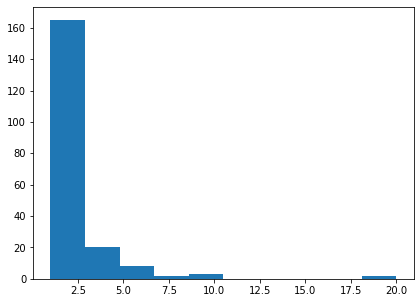

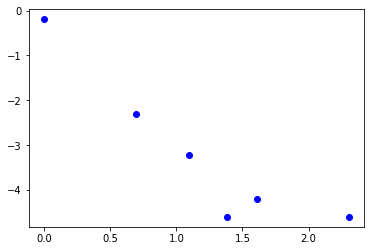

In [268]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

testMat = BAgen(200,1)
# uses networkx's implementation (optimized)
# testMat = nx.barabasi_albert_graph(200,1)
# testMat = nx.linalg.graphmatrix.adjacency_matrix(testMat).toarray()
print(testMat.shape)
fig.add_subplot(1,2,2)
tmp = np.histogram(sum(testMat))
plt.hist(sum(testMat))
plt.show()

ax = fig.add_subplot(1,2,2)
# is the degree distribution scale-free?
freqVec = tmp[0]
degVec = np.log(range(1,len(freqVec) + 1))
idx = np.where(freqVec==0)
freqVec = np.delete(freqVec, idx)
freqVec = np.log(freqVec/sum(freqVec))
degVec = np.delete(degVec, idx)
plt.plot(degVec, freqVec, 'bo')
plt.show()

Since I'm lazy, I'm going to rely on the NetworkX module to generate graphs of the remaining types.

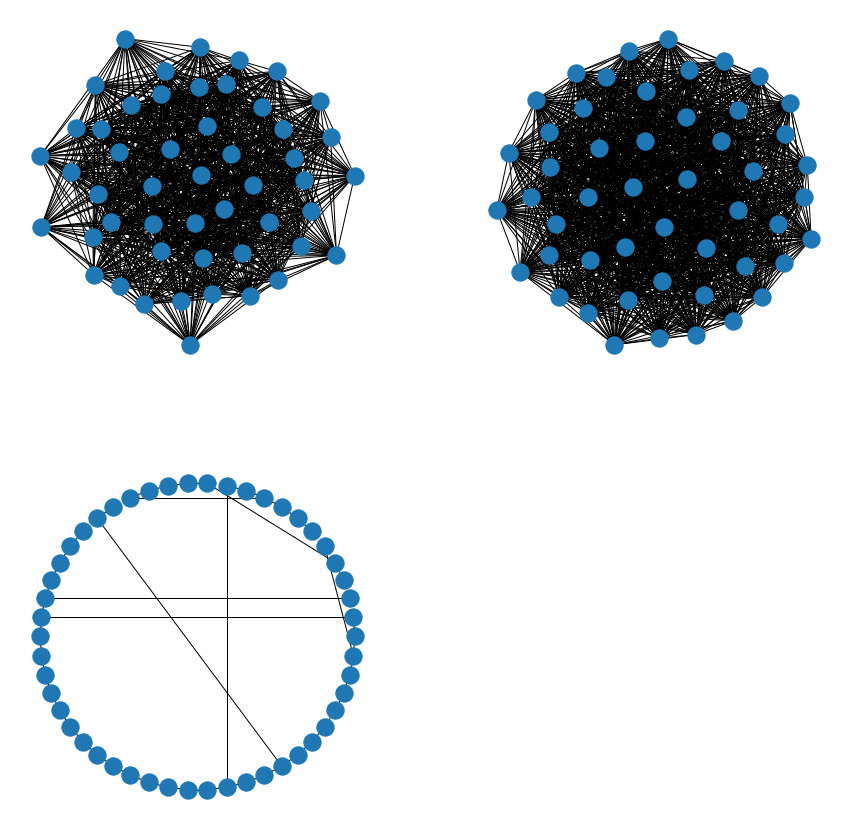

In [269]:
# E-R graph
ERgraph = nx.erdos_renyi_graph(50, 0.75)
# complete graph (just an E-R graph with the edge probability equal to 1)
completegraph = nx.erdos_renyi_graph(50, 1)
# small world
SWgraph = nx.watts_strogatz_graph(50, 2, 0.1)

# now to plot them
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.add_subplot(2,2,1)
nx.draw_spring(ERgraph)

fig.add_subplot(2,2,2)
nx.draw_spring(completegraph)

fig.add_subplot(2,2,3)
nx.draw_circular(SWgraph)

**Stochastic SIR network model**

The following code chunks are an SIR model with run a stochastic SIR model given an adjacency matrix and
and initially infected node, or individual. The stochastic simulation returns a subgraph of the infected
"chain" produced by the infection of a prespecified length `N`.

In [270]:
def SIRnet(thetaVec, N, adjMat, initInfected, chainBool, plotChain):
    '''
    +++++++++++++++++++++++++++++++
    SIRnet function: generates a "fuzzy" random walk of a network from a stochastic
        SIR simulation
    +++++++++++++++++++++++++++++++
    thetaVec     -- parameters of SIR model (see function for specifics)
    N            -- no. of infected at which simulation is terminated
    adjMat       -- adjacency matrix of contact network (should be numpy array)
    initInfected -- index of initial node infected (value between 0 and len(adjMat)-1)
    chainBool    -- Boolean variable controlling if the returned adjacency matrix is
                    the size of the original matrix; if true, it will return only the
                    adjacency matrix of the chain
    plotChain    -- do you want to plot the resulting chain?
                    (will only show the graph if chainBool = True)

    Note that we do not keep track of time because N < len(adjMat)
    '''

    beta = thetaVec[0] # probability of transmission assuming 1 contact
    gamma = thetaVec[1] # recovery rate

    if N > len(adjMat):
        print("ERROR: number of infected must be less than size of adjacency matrix!")
        return

    successBool = False
    # make sure we return subgraph of length w/N nodes
    while not successBool:
        infCount = 1

        # arrays containing total and infected populations
        NVec = np.array(range(len(adjMat))) # total no. of nodes
        infVec = np.array([initInfected], dtype = int)
        recVec = [] # empty array

        while (infCount < N) & (infCount > 0):

            # update susceptible pop. array
            deleteVec = np.sort(np.concatenate((infVec,recVec)))
            deleteVec = deleteVec.astype(int)
            susVec = np.delete(NVec, deleteVec)

            # calculate rates of new infections/recoveries
            atRiskSus = np.sum(adjMat[infVec,:], axis=0) # at-risk susceptibles
            atRiskSus = np.where(atRiskSus > 0)
            # take the intersect of at-risk susceptibles and susceptibles
            atRiskSus = np.intersect1d(susVec, atRiskSus)
            rateS2I = beta*len(atRiskSus)

            rateI2R = gamma*len(infVec)

            # Gillespie algorithm but w/o time
            totalRate = rateS2I + rateI2R
            rateS2I = rateS2I / totalRate
            rateI2R = rateI2R / totalRate

            tmpRand = np.random.uniform()
            if tmpRand <= rateS2I:
                # a random susceptible becomes infected
                infVec = np.sort(np.append(infVec, np.random.choice(atRiskSus, 1)))
                infCount += 1
            else:
                # an infected individual recovers
                tmpInd = np.random.choice(len(infVec))
                recVec = np.append(recVec, infVec[tmpInd])
                infVec = np.delete(infVec, tmpInd)
                infCount -= 1
                ## end of if statement
            ## end of while loop

        if infCount == N:
            successBool = True
            contactVec = np.sort(np.concatenate((infVec, recVec)))
            contactVec = contactVec.astype(int)

            # prune the adjacency matrix so it only contains connections to infected nodes
            keepMeMat = np.zeros((len(adjMat),len(adjMat)))
            keepMeMat[contactVec,:] = 1
            keepMeMat[:,contactVec] = 1
            infAdjMat = np.multiply(keepMeMat, adjMat)

            # only useful for plotting
            if plotChain:
                # plot the chain
                colorVec = np.array(['green']*len(infAdjMat))
                colorVec[infVec.astype(int)] = 'red'

            if chainBool:
                # return only the chain
                idxCols = np.argwhere(np.all(infAdjMat[..., :] == 0, axis=0))
                idxRows = np.argwhere(np.all(infAdjMat[..., :] == 0, axis=1))
                infAdjMat = np.delete(infAdjMat, idxCols, axis=1)
                infAdjMat = np.delete(infAdjMat, idxRows, axis=0)
                if plotChain:
                    # plot the chain
                    colorVec = np.delete(colorVec, idxCols)
                    nx.draw_spring(nx.from_numpy_matrix(infAdjMat), node_color=colorVec)
                    plt.show()

            print("Shape: ", infAdjMat.shape)
            print("Chain: ", infAdjMat)
        else:
            successBool = False

    ## end of while successBool loop
    return infAdjMat

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


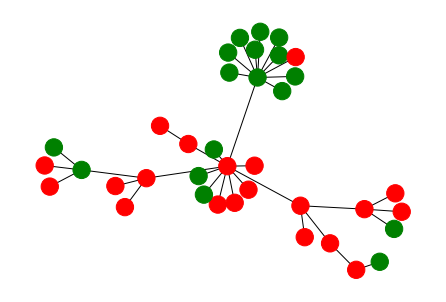

Shape:  (37, 37)
Chain:  [[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [271]:
# a test implementation of the above function
testMat = BAgen(50,1)
# testMat = nx.linalg.graphmatrix.adjacency_matrix(testMat).toarray()
print(testMat)
# testMat = nx.from_numpy_matrix(testMat)
thisTest = SIRnet(np.array([0.5, 0.1]), 20, testMat, 4, True, True)